# Fitting exponential growth and R0 for Kenya

In [3]:
using Plots,Distributions,ForwardDiff,Parameters,QuadGK,JLD2
using TransformVariables, LogDensityProblems, DynamicHMC, DynamicHMC.Diagnostics,Random

┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1273
┌ Info: Precompiling TransformVariables [84d833dd-6860-57f9-a1a7-6da5db126cff]
└ @ Base loading.jl:1273
┌ Info: Precompiling LogDensityProblems [6fdf6af0-433a-55f7-b3ed-c6c6e0b8df7c]
└ @ Base loading.jl:1273
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1273
┌ Info: Precompiling DynamicHMC [bbc10e6e-7c05-544b-b16e-64fede858acb]
└ @ Base loading.jl:1273


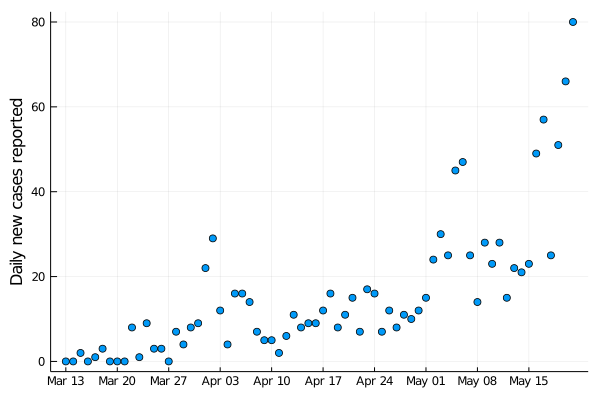

In [4]:
#Case data for Kenya
case_dates = ["Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27","Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11","Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24","Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 02","Apr 03","Apr 04","Apr 05","Apr 06","Apr 07","Apr08",
 "Apr 09","Apr 10","Apr 11","Apr 12","Apr 13","Apr 14","Apr 15","Apr 16","Apr 17","Apr 18","Apr 19","Apr 20","Apr 21","Apr 22","Apr 23","Apr 24","Apr 25","Apr 26","Apr 27","Apr 28","Apr 29","Apr 30","May 01","May 02","May 03","May 04","May 05","May 06","May 07","May 08","May 09","May 10","May 11","May 12","May 13","May 14","May 15","May 16","May 17","May 18","May 19","May 20","May 21"]

new_cases = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,3,0,0,0,8,1,9,3,3,0,7,4,8,9,22,29,12,4,16,16,14,7,5,5,2,6,11,8,9,9,12,16,8,11,15,7,17,16,7,12,8,11,10,12,15,24,30,25,45,47,25,14,28,23,28,15,22,21,23,49,57,25,51,66,80]
#Shorten to be from 13th March

f = findfirst(case_dates .== "Mar 13")
dates_str = case_dates[f:end]
cases = new_cases[f:end]

scatter(cases,lab = "",
    xticks = (1:7:length(dates_str),dates_str[1:7:end]),
    ylabel = "Daily new cases reported")


In [5]:
#Reparametrised negative binomial (mean μ, overdispersion parameter α)
function neg_binomial_mean_aggregation(μ,α)
    σ² = μ + α*μ^2
    p = 1 - ((σ² - μ)/σ²)
    r = μ^2/(σ² - μ)
    return rand(NegativeBinomial(r,p))
end


neg_binomial_mean_aggregation (generic function with 1 method)

In [6]:
@with_kw struct CaseData
    data
end
P = CaseData(data=cases)

function (P::CaseData)(θ)
    @unpack r,c₀,α = θ
    @unpack data = P
    
    log_likelihood = 0.
    for t in 1:length(data)
        d = data[t]
        μ = max(1e-10,c₀*exp(r*t))
        σ² = μ + α*μ^2
        p_negbin = 1 - (α*μ^2/σ²)
        r_negbin = 1/α
        log_likelihood += logpdf(NegativeBinomial(r_negbin,p_negbin),d)
    end
    return log_likelihood #+ logpdf(Exponential(10.),c₀) + logpdf(Normal(0.1,10.),r) + logpdf(Exponential(2.),α) 
end

# trans = as((parameters = as(Vector,asℝ₊, 1),))
trans = as((r = asℝ,α = asℝ₊,c₀ = asℝ₊))

ℓ = TransformedLogDensity(trans, P)
∇ℓ = LogDensityProblems.ADgradient(:ForwardDiff, ℓ)


ForwardDiff AD wrapper for TransformedLogDensity of dimension 3, w/ chunk size 3

In [7]:
results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇ℓ, 10000,
            initialization = (q = [0.1,log(3.),log(1.)], κ = GaussianKineticEnergy(3, 0.01) ));

┌ Info: finding initial optimum
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:71
┌ Info: found initial stepsize
│   ϵ = 0.0391
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:71
┌ Info: Starting MCMC
│   total_steps = 75
│   tuning = stepsize
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:102
┌ Info: MCMC progress
│   step = 1
│   seconds_per_step = 0.011
│   estimated_seconds_left = 0.82
│   ϵ = 0.0391
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: Starting MCMC
│   total_steps = 25
│   tuning = stepsize and LinearAlgebra.Diagonal metric
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:102
┌ Info: MCMC progress
│   step = 1
│   seconds_per_step = 0.0094
│   estimated_seconds_left = 0.23
│   ϵ = 0.0189
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: adaptation finished
│   adapted_kinetic_energ

┌ Info: MCMC progress
│   step = 1801
│   seconds_per_step = 0.0019
│   estimated_seconds_left = 16.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 1901
│   seconds_per_step = 0.0021
│   estimated_seconds_left = 17.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2001
│   seconds_per_step = 0.002
│   estimated_seconds_left = 16.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2101
│   seconds_per_step = 0.0021
│   estimated_seconds_left = 17.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2201
│   seconds_per_step = 0.0019
│   estimated_seconds_left = 15.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2301
│   seconds_per_step = 0.002
│   estimated_seconds_le

┌ Info: MCMC progress
│   step = 6401
│   seconds_per_step = 0.0023
│   estimated_seconds_left = 8.4
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6501
│   seconds_per_step = 0.002
│   estimated_seconds_left = 7.1
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6601
│   seconds_per_step = 0.002
│   estimated_seconds_left = 6.6
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6701
│   seconds_per_step = 0.0021
│   estimated_seconds_left = 6.9
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6801
│   seconds_per_step = 0.0021
│   estimated_seconds_left = 6.9
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6901
│   seconds_per_step = 0.0018
│   estimated_seconds_left = 

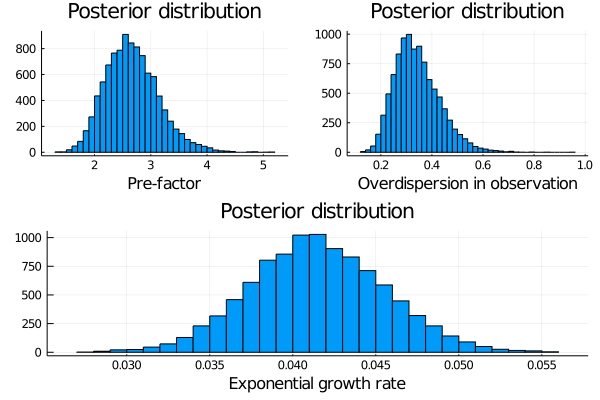

In [8]:
posterior = transform.(trans, results.chain)
posterior_r = [θ.r for θ in posterior]
posterior_α = [θ.α for θ in posterior]
posterior_c₀ = [θ.c₀ for θ in posterior]

r_plt = histogram(posterior_r,bins = 50,lab = "",xlabel = "Exponential growth rate",title = "Posterior distribution" )
α_plt = histogram(posterior_α,bins = 50,lab = "",xlabel = "Overdispersion in observation",title = "Posterior distribution" )
c₀_plt = histogram(posterior_c₀,bins = 50,lab = "",xlabel = "Pre-factor",title = "Posterior distribution" )

layout = @layout [a b;c]
plt_posterior = plot(c₀_plt,α_plt,r_plt,layout = layout)

In [26]:
tilted_weibull(t,r,α,θ) = exp(-r*t)*pdf(Weibull(α,θ),t)
function mgf_weibull(r)
    f = t -> tilted_weibull(t,r,2.826,5.665)
    quadgk(f,0,30.)[1]
end

mgf_weibull (generic function with 1 method)

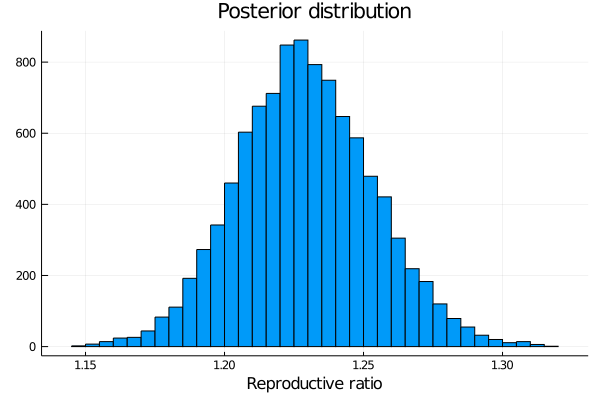

In [27]:
posterior_R₀ = [1/mgf_weibull(r) for r in posterior_r]
R₀_plt = histogram(posterior_R₀,bins = 50,lab = "",xlabel = "Reproductive ratio",title = "Posterior distribution" )


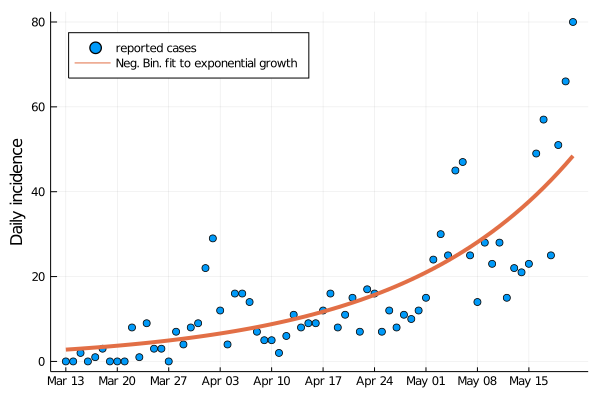

In [29]:
poserior_incidence = [ mean([posterior_c₀[i]*exp(posterior_r[i]*t) for i = 1:length(posterior_r)]) for t = 1:70]
plt_exp_growth_fit = scatter(1:70,cases,lab = "reported cases",legend = :topleft,
    xticks = (1:7:length(dates_str),dates_str[1:7:end]),
    ylabel = "Daily incidence")
plot!(plt_exp_growth_fit,poserior_incidence,lw=4,lab = "Neg. Bin. fit to exponential growth")

In [32]:
savefig(plt_exp_growth_fit,"fit_to_daily_cases.png")
savefig(R₀_plt,"posterior_distribution_R0.png")
savefig(plt_posterior,"fit_posterior_distributions.png")
@save "posterior_distribution_R0.jld2" posterior_R₀

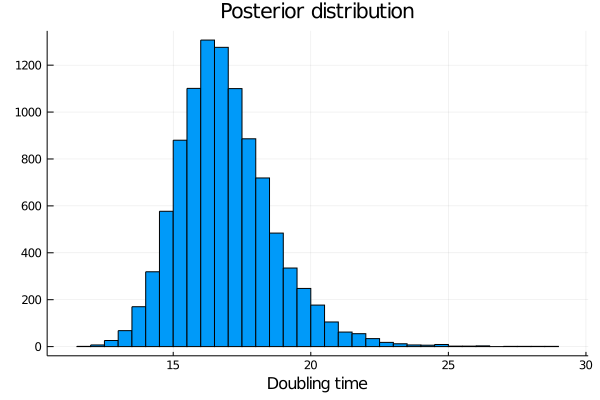

In [35]:
posterior_doubling_time = [log(2)/r for r in posterior_r]
doubling_time_plt = histogram(posterior_doubling_time,bins = 50,lab = "",xlabel = "Doubling time",title = "Posterior distribution" )


In [37]:
savefig(doubling_time_plt,"posterior_distribution_doubling_time.png")

mean(posterior_doubling_time)

16.890535209956642

In [29]:
posterior_crude_I₀ = [posterior_c₀[i]*exp(7*posterior_r[i])/0.025 for i = 1:length(posterior_r)]
mean(posterior_crude_I₀)

142.18043798759047

In [30]:
mean(posterior_crude_I₀)*9/mean(posterior_R₀)

1041.1362862468586

In [12]:
mean(posterior_c₀)

2.6696062539121073